<a href="https://colab.research.google.com/github/udsey/DS_projets/blob/main/flower_classification_tl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import random_split, Subset
import torch.nn.functional as F
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
from PIL import Image
from itertools import chain
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from sklearn.model_selection import train_test_split
import random
import re
import pandas as pd

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 8

In [ ]:
def plot_img_batch(inp, title):
    fig, axs = plt.subplots(nrows=1,
                            ncols=inp.shape[0],
                            figsize=(20, 8))
    for i in range(inp.shape[0]):
        img = inp[i].numpy().transpose((1, 2, 0))
        axs[i].imshow(img)
        if title is not None:
            axs[i].set_title(title[i])
        axs[i].axis('off')
    plt.show()

def train_val_split(root, val_size):
    path = set(chain(*[[(os.path.join(root, dir, x), dir) for x in os.listdir(root + dir)] for dir in os.listdir(root)]))
    val_size = int(len(path)*val_size)
    val_path = random.sample(path, val_size)
    train_path, train_label = list(zip(*(path - set(val_path))))
    val_path, val_label = list(zip(*val_path))
    return train_path, val_path, train_label, val_label

def write_to_df(pred, pathes, df):
    for i, path in enumerate(pathes):
        df.loc[df.Id==path, 'Category'] = int(pred[i])    

В этом задании необходимо решить задачу классификации изображений, а именно цветов на 102 класса. В этом соревновании можно объединяться в команды не более 3 человек. В день возможно отправлять не более 10 решений. Задание считается засчитанным при метрике >= 0.93 на public тесте. Помните, что решения принимаются только в том формате, который представлен в файле sample_submission.csv.
Метрика соревнования - classification accuracy.

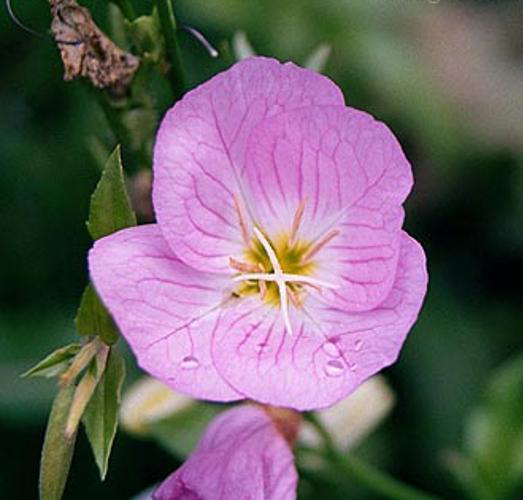

In [ ]:
root = '../input/flowerdata-module5/train/train'
label = '1'
path = 'image_06734.jpg'
Image.open(os.path.join(root, label, path))

In [ ]:
class FlowerDataset(torch.utils.data.Dataset):
    
    def __init__(self, paths, labels, transform, test=False):
        self.transform = transform
        self.paths = paths
        self.label = labels
        self.test = test
        
        
    def __len__(self):
        return len(self.paths)


    def __getitem__ (self, idx):
        label = self.label[idx]
        data = Image.open(self.paths[idx])
        data = self.transform(data)
        if self.test == False:
            label = int(label)
        return data, label

In [ ]:
root = '../input/flowerdata-module5/train/train/'
val_size = 0.3

train_paths, val_paths, train_labels, val_labels = train_val_split(root, val_size)

In [ ]:
val_transform = transforms.Compose([
                            transforms.Resize(size=256),
                            transforms.CenterCrop(size=224),
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                        ])
train_transform = transforms.Compose([
                            transforms.RandomResizedCrop(256),
                            transforms.CenterCrop(size=224),
                            transforms.RandomHorizontalFlip(p=0.5),
                            transforms.RandomRotation(degrees=(0, 360)),
                            transforms.ColorJitter(),
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                            ])

In [ ]:
train_dataset = FlowerDataset(paths=train_paths,
                              labels=train_labels,
                              transform=train_transform)

val_dataset = FlowerDataset(paths=val_paths,
                            labels=val_labels,
                            transform=val_transform)


train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_batch_gen = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

dataloaders = {'train': train_batch_gen,
               'val': val_batch_gen}
dataset_sizes = {'train' : len(train_dataset),
                 'val' : len(val_dataset)}

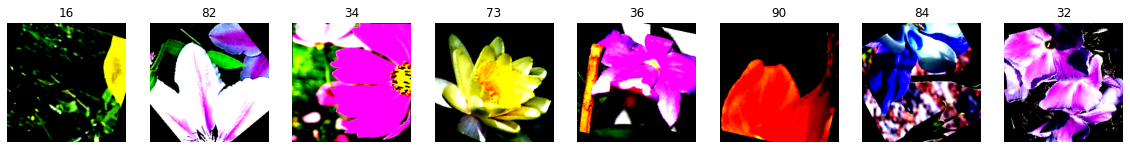

In [ ]:
inputs, classes = next(iter(train_batch_gen))
classes = classes.tolist()
plot_img_batch(inputs, classes)

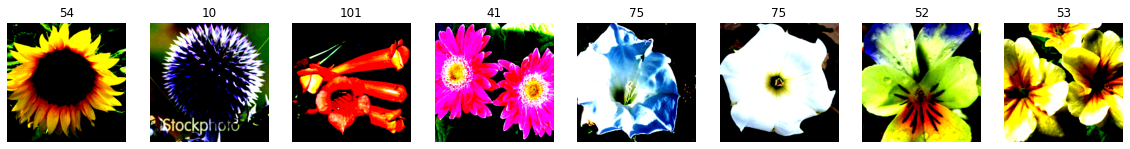

In [ ]:
inputs, classes = next(iter(val_batch_gen))
classes = classes.tolist()
plot_img_batch(inputs, classes)

# Transfer Learning

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)-1

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
num_classes = 102
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, num_classes)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=40)

Epoch 0/39
----------
train Loss: 3.2537 Acc: 0.2745
val Loss: 1.5203 Acc: 0.5908

Epoch 1/39
----------
train Loss: 1.7236 Acc: 0.5869
val Loss: 0.8033 Acc: 0.7939

Epoch 2/39
----------
train Loss: 1.2968 Acc: 0.6776
val Loss: 0.5217 Acc: 0.8641

Epoch 3/39
----------
train Loss: 1.0193 Acc: 0.7552
val Loss: 0.4059 Acc: 0.8891

Epoch 4/39
----------
train Loss: 0.8692 Acc: 0.7929
val Loss: 0.3821 Acc: 0.8947

Epoch 5/39
----------
train Loss: 0.8128 Acc: 0.7955
val Loss: 0.3003 Acc: 0.9191

Epoch 6/39
----------
train Loss: 0.7567 Acc: 0.8088
val Loss: 0.2909 Acc: 0.9211

Epoch 7/39
----------
train Loss: 0.6248 Acc: 0.8422
val Loss: 0.2418 Acc: 0.9349

Epoch 8/39
----------
train Loss: 0.5687 Acc: 0.8609
val Loss: 0.2313 Acc: 0.9394

Epoch 9/39
----------
train Loss: 0.5442 Acc: 0.8655
val Loss: 0.2195 Acc: 0.9435

Epoch 10/39
----------
train Loss: 0.5222 Acc: 0.8757
val Loss: 0.2108 Acc: 0.9455

Epoch 11/39
----------
train Loss: 0.5176 Acc: 0.8786
val Loss: 0.1964 Acc: 0.9511

Ep

# Model test

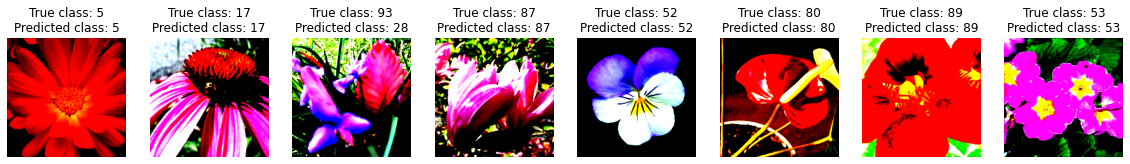

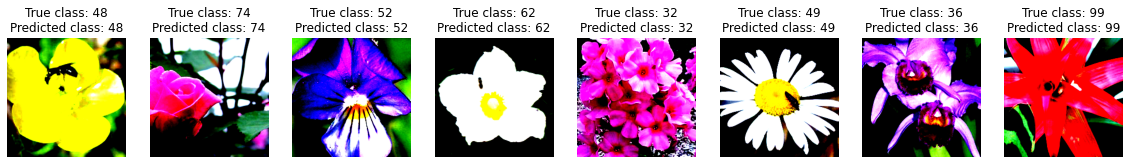

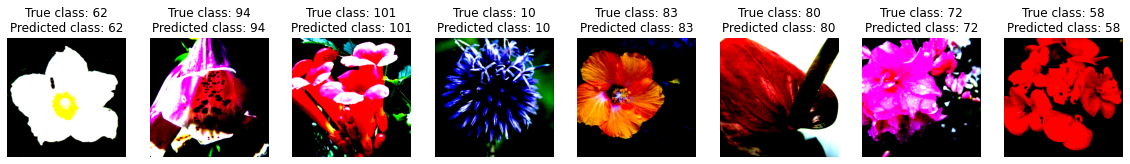

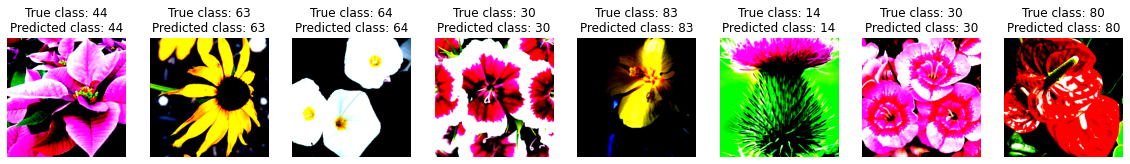

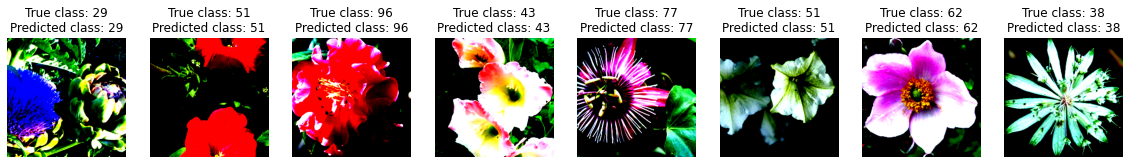

In [ ]:
for _ in range(5):
    inputs, classes = next(iter(val_batch_gen))
    classes = classes.tolist()

    inputs = inputs.to(device)
    _, pred_classes = torch.max(model_ft(inputs), 1)
    pred_classes += 1
    text_string = 'True class: {}\nPredicted class: {}'
    titles = [text_string.format(x, y) for x, y in zip(classes, pred_classes.tolist())]
    inputs = inputs.cpu()

    plot_img_batch(inputs, titles)

# Prediction

In [ ]:
test_transform = transforms.Compose([
                            transforms.Resize(size=256),
                            transforms.CenterCrop(size=224),
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                        ])

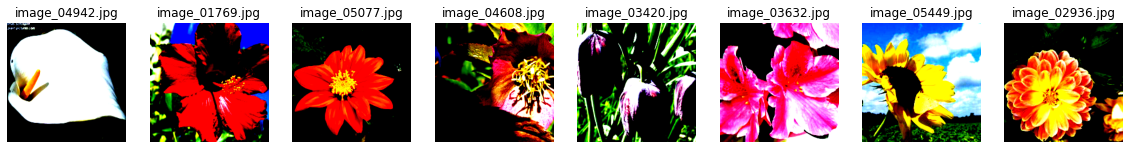

In [ ]:
test_root = '../input/flowerdata-module5/test/test'
img_path = os.listdir(test_root)
test_paths = [os.path.join(test_root, img) for img in img_path]

test_dataset = FlowerDataset(paths=test_paths,
                             labels=img_path,
                             transform=test_transform,
                             test=True)



test_batch_gen = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
inputs, pathes= next(iter(test_batch_gen))
plot_img_batch(inputs, pathes)

In [ ]:
submission = pd.read_csv('../input/flowerdata-module5/sample_submission.csv')
submission.head()

,Id,Category
0,image_00028.jpg,1
1,image_00059.jpg,1
2,image_00061.jpg,1
3,image_00063.jpg,1
4,image_00071.jpg,1


In [ ]:
for inputs, pathes in test_batch_gen:
    inputs = inputs.to(device)
    _, pred_classes = torch.max(model_ft(inputs), 1)
    pred_classes += 1
    write_to_df(pred_classes, pathes, submission)

In [ ]:
submission.to_csv('submission_2.csv', index=False)